# Relative Derived Complex

Compute $(M,L)'$. For dimension 2 there are not many cases: If an edge is in $M \setminus L$ it must be subdivided. 
If a triangle is in $M$ and $L$ contains:
   - zero of its edges: regular subdivision
   - one of its edges: special subdivision with 21 simplices
   - two of its edges: special subdivision with 17 simplices
   - three of its edges: special subdivision with 13 simplices
   - all the triangle: no subdivision
   

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import scipy as sp
import itertools
import copy

!pip install nbimporter
import nbimporter
from ExtendingAlpha import getAlphaComplex, draw_2d_simplicial_complex
from BarySub import AbstractSubdivision
from Supplement import draw_Sup

Defaulting to user installation because normal site-packages is not writeable


In [10]:
pointsL = [ [0.0,0.0 ],[1.0, -1.0], [1.0, 1.0] ,[2.0,0.0] ]
pointsL = 0.1*np.array( pointsL )

pointsM = pointsL.copy()

M = [[0,1], [0,2],[1,2],[1,3],[2,3],[0,1,2], [1,2,3]]
L = [[1,3],[2,3], [1,2]]
#L = [[1,3]]

Generate the points of $L$

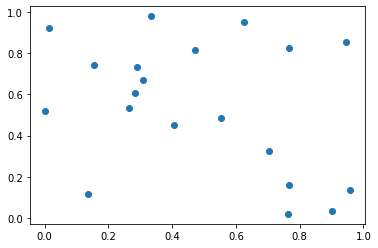

In [11]:
np.random.seed(12)
#np.random.seed(None)
pointsL = np.random.random_sample(size=(20,2))
plt.scatter(pointsL[:,0], pointsL[:,1])

In [12]:
L = getAlphaComplex(pointsL, .15)

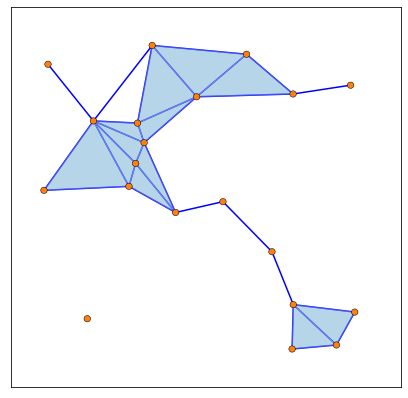

In [13]:
draw_2d_simplicial_complex(L, pointsL)

Now the points of $M$

In [14]:
pointsM = pointsL.copy()
M = getAlphaComplex(pointsM, 4)

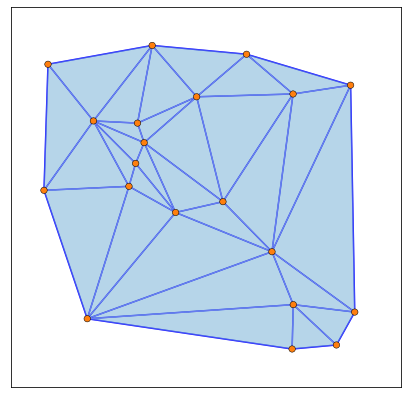

In [15]:
draw_2d_simplicial_complex(M, pointsM)

In [16]:
MminusL = [ x for x in M if x not in L ]
MminusL

[[0, 2, 16],
 [0, 2, 7],
 [6, 17, 18],
 [8, 12, 13],
 [8, 13, 18],
 [1, 7, 11],
 [8, 12, 19],
 [1, 11, 19],
 [0, 14, 16],
 [9, 10, 11],
 [9, 11, 15],
 [11, 15, 19],
 [8, 15, 19],
 [4, 9, 15],
 [4, 6, 15],
 [6, 15, 18],
 [8, 15, 18],
 [6, 15],
 [4, 6],
 [4, 15],
 [8, 12],
 [8, 18],
 [9, 11],
 [6, 17],
 [10, 11],
 [2, 7],
 [1, 11],
 [11, 19],
 [2, 16],
 [15, 19],
 [8, 13],
 [11, 15],
 [7, 11],
 [15, 18]]

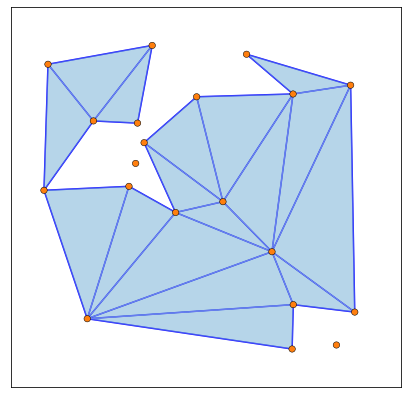

In [17]:
draw_2d_simplicial_complex(MminusL, pointsM)

### Relative Complex

We need to address the restricted subdivision of the triangle

In [18]:
Subs = {}

for i in range(2,4+1):
    Subs[i] = AbstractSubdivision(i)

In [19]:
def RelAbsSub(n , lockedFaces):
    '''Function for the relative abstract subdivision of a triangle
    
    Starts from the regular abstract subdivision, and removes the simplices that are not 
    there in the relative case. Currently only works for triangles, but the concept 
    should be general.
    Params:
    n (int), either 2 or 2: the dimension of the simplex to subdivide
    lockedFaces (int): 1,2 or 3. Assumes the ordering [0,1] , [0,1] [1,2], all edges
    '''
    
    if n <= 1 or n > 3:
        raise ValueError("Dimension ", n, " is not supported")  
        
            
    def lockFace(subsimps, face):
        '''Change the list Sub[n] by locking one specific face'''
        
        # For n = 3, the face can be [0,1], [0,2] or [1,2]
        
        
        subsimps = [ s for s in subsimps if s[0] != face ] # remove the two edges that start in face
        subsimps = [ s for s in subsimps if s[1] != face ] # remove the two triangles through face and the edge that ends in face
        subsimps.append( [ [face[0]] , [face[1]] ] )
        subsimps.append( [ [0,1,2] , [face[0]] , [face[1]] ] )
        
        return subsimps
        
    subsimps = Subs[n].copy()
    
    if lockedFaces == 0:
        pass
    
    if lockedFaces == 1: # assumes it's [0,1]
        subsimps = lockFace(subsimps, [0,1])
        
    if lockedFaces==2: # assumes it's [0,1] and [1,2]
        subsimps = lockFace(subsimps, [0,1])
        subsimps = lockFace(subsimps, [1,2])
        
    if lockedFaces==3: # it's all
        subsimps = lockFace(subsimps, [0,1])
        subsimps = lockFace(subsimps, [1,2])
        subsimps = lockFace(subsimps, [0,2])
        
    return subsimps
        

In [20]:
relsub = RelAbsSub(3,3)
relsub

[[[0, 1, 2], [2]],
 [[0, 1, 2], [1]],
 [[0, 1, 2], [0]],
 [[0], [1]],
 [[0, 1, 2], [0], [1]],
 [[1], [2]],
 [[0, 1, 2], [1], [2]],
 [[0], [2]],
 [[0, 1, 2], [0], [2]]]

In [21]:
# Save the 3 special cases
RelSubs = {}

for i in range(4):
    RelSubs[(3,i)] = RelAbsSub( 3, i )

In this case, all the vertices will be in common between $M$ and $L$

In [22]:
def RelSub( M, pointsM, L, pointsL ):
    
    # generate abstract triangle cases
    RelSubs = {}

    for i in range(4):
        RelSubs[(3,i)] = RelAbsSub( 3, i )
    
    
    n_pointsL = pointsL.shape[0]
    
    MminusL = [ x for x in M if x not in L ] # M minus L
    NVerts = pointsL.shape[0] + len(MminusL) # How many vertices in the relative sub
    
    SubPoints = np.zeros((NVerts, 2))
    
    # the first points are just the points of L
    SubPoints[ 0 : n_pointsL , : ] = pointsL.copy()
    
    for i in range(len(MminusL)): # for every simplex in the subset
        
        bary = np.mean(pointsM[MminusL[i],:], axis=0) # compute barycenter
        SubPoints[i+n_pointsL,:] = bary # add it in position
        
    subdivision = []
    
    subdivision.extend(L) # first, add all L
    
    # iterate over all simplices in the difference
    for s, sigma in enumerate(MminusL):
        
        l = len(sigma)
        #print('* Simplex to subdivide is ', sigma)
        
        if l == 3: # if triangle
            # find how many and which edges of sigma are in L
            flag1 = ( [sigma[0],sigma[1]] in L)

            flag2 = ( [sigma[1],sigma[2]] in L)
            
            flag3 = ( [sigma[0],sigma[2]] in L)
            
            nLocked = sum( [ 1 if x else 0 for x in [flag1, flag2, flag3] ] )

            # map the vertices accordingly
            
            if nLocked == 0: # if None are in L
                
                Map = [0,1,2] # the basic ordering is fine
                
            elif nLocked == 3: # if all are in L 
            
                Map = [0,1,2] # the basic ordering is fine as well
            
            elif nLocked == 1:
                
                if flag1:
                    Map = [0,1,2] # the basic ordering is fine
                elif flag2:
                    Map = [1,2,0] # first permutation
                elif flag3:
                    Map = [2,0,1] # second permutation
            elif nLocked == 2:
                
                if not flag3: # if it's NOT flag 3, so 1 and 2
                    Map = [0,1,2] # the basic ordering is fine
                elif not flag1: # if it's NOT flag 1, so 2 and 3
                    Map = [1,2,0] # first permutation
                elif not flag2:
                    Map = [2,0,1] # second permutation
                
            #print('nLocked is: ', nLocked)
            #print('The map is ', Map)
            # Then use the appropriate abstract subdivision of a triangle
            for sub in RelSubs[(3, nLocked)]:
                
                #print(' Abstract sub is: ',sub)
                
                newSimplex = []
                
                for face in sub:
                    
                    #print('  Abstract vertex: ', face)
                    
                    # HERE WE MUST USE THE MAP to take into account that the Relative Abstract Subdivision is on the standard triangle
                    thisFace = [ sigma[Map[h]] for h in face ]
                    
                    # AND THEN REORDER
                    thisFace = list(sorted(thisFace))
                     
                    #print('  This vertex: ', thisFace)
                    
                    if len(thisFace)>1: # if it's not a vertex
                        
                        #print('    Barycenter')
                        
                        thisIndex = MminusL.index(thisFace)

                        #print("    Goes to index ", thisIndex)

                        newSimplex.append(thisIndex + n_pointsL)
                        
                        #print("    Translating to ", thisIndex+ n_pointsL)

                    else:
                        #print('    Original Vertex')
                        thisIndex = thisFace[0]
                        newSimplex.append(thisIndex)
                        #print('    Goes to index ', thisIndex)
                        
                newSimplex = list(sorted(newSimplex))
        
                subdivision.append( newSimplex )
                #print('Adding ',newSimplex)
                
        
        else: # all else must be subdivided normally
            for sub in Subs[l]:
                
                #print(' Abstract sub is: ', sub)
            
                newSimplex = []
                for face in sub:
                    
                    #print('  Abstract vertex: ', face)

                    thisFace = [ sigma[h] for h in face ]
                     
                    #print('  This vertex: ', thisFace)

                    if len(thisFace)>1: # if it's not a vertex
                        
                        #print('    Barycenter')
                        
                        thisIndex = MminusL.index(thisFace)

                        #print("    Goes to index ", thisIndex)

                        newSimplex.append(thisIndex + n_pointsL)
                        
                        #print("    Translating to ", thisIndex+ n_pointsL)

                    else:
                        #print('    Original Vertex')
                        thisIndex = thisFace[0]
                        newSimplex.append(thisIndex)
                        #print('    Goes to index ', thisIndex)
                        
                newSimplex = list(sorted(newSimplex))
        
                subdivision.append( newSimplex )
                #print('Adding ',newSimplex)
        
    return subdivision, SubPoints

In [23]:
MminusL;

In [24]:
relsub, newpoints = RelSub(M, pointsM, L, pointsL);

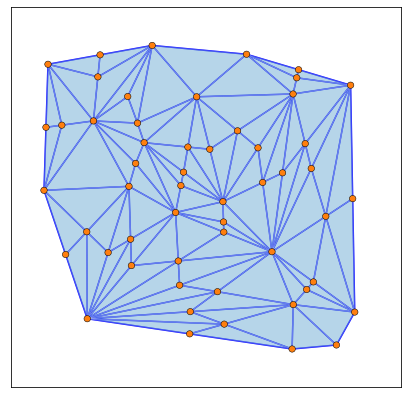

In [25]:
draw_2d_simplicial_complex(relsub, newpoints)

In [26]:
relsub;

In [27]:
10*newpoints;

In [28]:
Subs[2]

[[[0, 1], [1]], [[0, 1], [0]]]

## Plot

In [29]:
from Supplement import draw_Sup

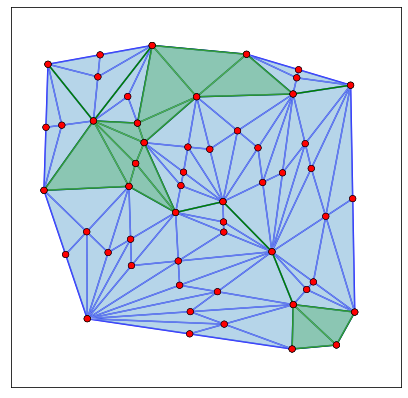

In [30]:
Lbar = []
indices = []
draw_Sup( relsub , L , Lbar, indices, pos = newpoints, posSub = pointsL)

## Tight Supplement

In [31]:
def tightSupp( L , pointsL, M, pointsM ):
    ''' Assuming L < M is a subcomplex of M, compute the "tight" supplement of L in M, 
    that is the set of simplices in (M,L \cup L_out)' that do not have any vertex in L.
    For our current case L_out is empty, so this reduces to \sigma \in (M,L)' such that
    no vertex of \sigma is a simplex of L (eq. has a vertex in L').
    
    '''
    
    
    # compute vertices of L
    L0 = list(set( [ vert for sigma in L for vert in sigma ] ))
    
    # Compute Lout (IT WILL BE EMPTY!)
    Lout = [ simp for simp in M if all( x not in L0 for x in simp)  ]

    
    relsubs, newpoints = RelSub(M, pointsM, L, pointsL)
    
    # Find which vertices in sM are vertices of L
    
    SubComplexIndices = []
    for i in range(newpoints.shape[0]):
        
        if any( all(newpoints[i,:] == pointsL[j,:]) for j in range(pointsL.shape[0]) ):
            
            SubComplexIndices.append(i)
            
    RelSupPoints = newpoints.copy()
    
    # keep simplices if they are not in the smaller complex
    Lbar = [ m for m in relsubs if all([s not in SubComplexIndices for s in m ])  ]
    
    # Add vertices to Lbar!
    verticesLbar = [ [n] for n in range(newpoints.shape[0]) if n not in SubComplexIndices ] 
    
    Lbar = verticesLbar + Lbar
            
    
    return Lbar, SubComplexIndices

In [32]:
LbarTight, indices = tightSupp(L, pointsL, M, pointsM)

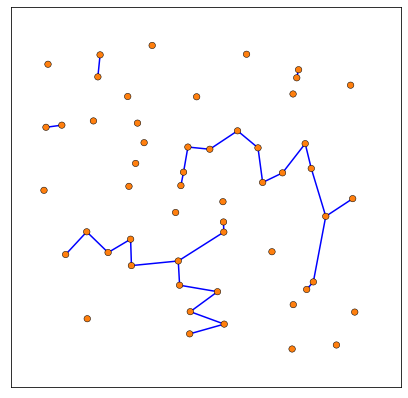

In [33]:
draw_2d_simplicial_complex(LbarTight, newpoints)

## Compute outer rim
In this example, we have more than one red connected component which does not correspond to a generator of the original subcomplex. 
This can happen because of non-convexity of the subcomplex: so when you extend it you add things to the supplement which were not cycles.
This can be solved by identifying which edges in the full extended complex are "outer": i.e. sum all top-dimensional simplices and compute the boundary. 
Then if any CC in red in the supplement contains vertices that correspond to an edge in the outer rim, they are to be discarded. <br>
This is essentially (must be proven though) the same as identifying the boundary of $M \cong D^d$ to a point at infinity, making it into $S^d$.

In [34]:
EL = [ x for x in relsub if len(x)==2 ]
EL = list(sorted(EL))

Triangles = [ x for x in relsub if len(x)==3 ]
Triangles = list(sorted(Triangles))

In [35]:
BoundaryOfTriangles = np.zeros( ( len(EL), len(Triangles) ), dtype=int)


for i,T in enumerate(Triangles):


    e0 = EL.index( [T[0], T[1]] )
    e1 = EL.index( [T[1], T[2]] )
    e2 = EL.index( [T[0], T[2]] )

    BoundaryOfTriangles[ e0 , i ] = 1
    BoundaryOfTriangles[ e1 , i ] = 1
    BoundaryOfTriangles[ e2 , i ] = 1

In [36]:
outerCycle = np.sum( BoundaryOfTriangles, axis = 1 )
outerCycle = np.mod(outerCycle, 2)

In [37]:
markedEdges = [ e for i,e in enumerate(EL) if outerCycle[i]==1 ]

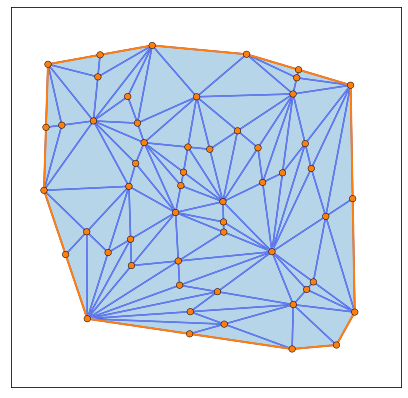

In [38]:
draw_2d_simplicial_complex(relsub, newpoints, markedEdges=markedEdges)

## Connected components of tight $\bar{L}$
And which contain a vertex from the boundary of $M$

In [39]:
LbarCopy = copy.deepcopy(LbarTight)
Lbar;

In [40]:
Vertices = [ s for s in LbarCopy if len(s) == 1 ]
Vertices;

In [41]:
Edges = [ s for s in LbarCopy if len(s) == 2 ]
Edges;

In [42]:
CC = Vertices
CC;

Iterate over all edges. For each, find which connected components contains the source and which the target. IF THEY ARE DIFFERENT, join them into source and delete target.

In [43]:
for e in Edges:
    
    source = next(i for i,c in enumerate(CC) if e[0] in c )
    target = next(i for i,c in enumerate(CC) if e[1] in c )
    
    if source != target:
        CC[source].extend( CC[target] )
        del CC[target]

In [44]:
CC

[[20, 48],
 [21, 45],
 [22, 43],
 [28],
 [32, 31, 49, 27, 25, 52, 46, 47, 30, 29, 44, 42, 51],
 [36, 35, 34, 37, 33, 39, 38, 53, 26, 24, 41, 23, 50, 40]]

## Exclude CCs if they touch on the boundary

In [45]:
markedEdges;

In [46]:
BanishedVertices = set()

for e in markedEdges:
    BanishedVertices.add( e[0] )
    BanishedVertices.add( e[1] )
    
BanishedVertices = list(sorted(BanishedVertices))
BanishedVertices

[2, 3, 4, 6, 7, 10, 11, 16, 17, 38, 43, 44, 45, 48, 52]

In [47]:
ValidCC = []
ExcludeCC = []

for c in CC:
    
    if any( v in BanishedVertices for v in c ):
        
        ExcludeCC.append(c)
    else:
        
        ValidCC.append(c)

In [48]:
ValidCC

[[28]]

In [49]:
ExcludeCC

[[20, 48],
 [21, 45],
 [22, 43],
 [32, 31, 49, 27, 25, 52, 46, 47, 30, 29, 44, 42, 51],
 [36, 35, 34, 37, 33, 39, 38, 53, 26, 24, 41, 23, 50, 40]]

### Exclude a vertex if its connected component contains any from the banished vertices

In [50]:
excludedVerts = []

list(excludedVerts.extend(c) for c in ExcludeCC)
excludedVerts;

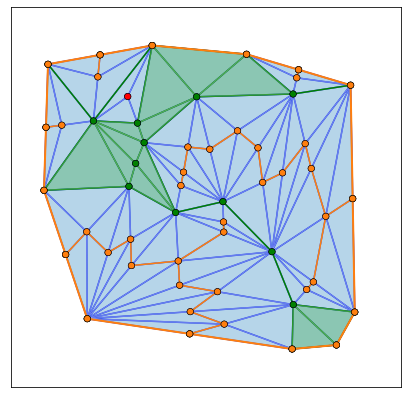

In [51]:
draw_Sup( relsub , L , LbarTight, indices, pos = newpoints, posSub = pointsL, boundaryComponent = markedEdges, excludedVerts=excludedVerts )

# Now the representative cycles in $L$

In [52]:
M[6]

[13, 17, 18]

In [53]:
10*newpoints

array([[1.54162842, 7.40049697],
       [2.63315015, 5.33739393],
       [0.14574962, 9.18747008],
       [9.00714854, 0.33421428],
       [9.56949336, 1.37209321],
       [2.83828353, 6.06083184],
       [9.44225136, 8.52735541],
       [0.02259234, 5.21226027],
       [5.52037633, 4.85377414],
       [7.68134154, 1.60716753],
       [7.6456045 , 0.20809798],
       [1.35210178, 1.16273017],
       [3.09897584, 6.71452645],
       [4.71229778, 8.16168298],
       [2.89586784, 7.33125978],
       [7.02622355, 3.27569476],
       [3.34647529, 9.78058079],
       [6.24582112, 9.50313525],
       [7.67475651, 8.25009253],
       [4.06640302, 4.51308411],
       [1.67795111, 8.78951595],
       [0.56999013, 7.26674244],
       [7.78760966, 8.7601944 ],
       [4.44388332, 6.57666119],
       [5.96914354, 7.08851655],
       [1.33594809, 3.90412813],
       [4.22858507, 5.36046157],
       [2.68388498, 3.67106941],
       [2.59465718, 8.17077918],
       [5.55968261, 0.99266523],
       [5.

In [54]:
MminusL

[[0, 2, 16],
 [0, 2, 7],
 [6, 17, 18],
 [8, 12, 13],
 [8, 13, 18],
 [1, 7, 11],
 [8, 12, 19],
 [1, 11, 19],
 [0, 14, 16],
 [9, 10, 11],
 [9, 11, 15],
 [11, 15, 19],
 [8, 15, 19],
 [4, 9, 15],
 [4, 6, 15],
 [6, 15, 18],
 [8, 15, 18],
 [6, 15],
 [4, 6],
 [4, 15],
 [8, 12],
 [8, 18],
 [9, 11],
 [6, 17],
 [10, 11],
 [2, 7],
 [1, 11],
 [11, 19],
 [2, 16],
 [15, 19],
 [8, 13],
 [11, 15],
 [7, 11],
 [15, 18]]

In [55]:
L

[[0, 5, 12],
 [13, 17, 18],
 [13, 16, 17],
 [3, 4, 9],
 [0, 1, 7],
 [0, 1, 5],
 [5, 12, 19],
 [1, 5, 19],
 [0, 12, 14],
 [13, 14, 16],
 [12, 13, 14],
 [3, 9, 10],
 [6, 18],
 [3, 4],
 [4, 9],
 [12, 13],
 [12, 19],
 [14, 16],
 [3, 10],
 [0, 2],
 [0, 5],
 [5, 19],
 [17, 18],
 [0, 14],
 [8, 15],
 [13, 14],
 [13, 17],
 [3, 9],
 [5, 12],
 [0, 1],
 [0, 7],
 [9, 10],
 [0, 16],
 [1, 5],
 [13, 16],
 [12, 14],
 [1, 19],
 [9, 15],
 [0, 12],
 [1, 7],
 [8, 19],
 [13, 18],
 [16, 17]]

In [56]:
offset = pointsM.shape[0]
ReprEdges = []

EL = [ x for x in M if len(x)==2 ]
EL = list(sorted(EL))

for simps in ValidCC:
    
    ReprTriangles = []
   
    for s in simps:

        simplex = M[s - offset]
        if len(simplex) == 3:

            ReprTriangles.append(simplex)

    
    Boundary = np.zeros( ( len(EL), len(ReprTriangles) ), dtype=int)

    for i,T in enumerate(ReprTriangles):

        e0 = EL.index( [T[0], T[1]] )
        e1 = EL.index( [T[0], T[2]] )
        e2 = EL.index( [T[1], T[2]] )
        
        Boundary[ e0 , i ] = 1
        Boundary[ e1 , i ] = 1
        Boundary[ e2 , i ] = 1
    
    outerCycle = np.sum( Boundary, axis = 1 )
    outerCycle = np.mod(outerCycle, 2)
    
    ReprEdges.extend([ e for i,e in enumerate(EL) if outerCycle[i]==1 ] )
        

In [57]:
relsub

[[0, 5, 12],
 [13, 17, 18],
 [13, 16, 17],
 [3, 4, 9],
 [0, 1, 7],
 [0, 1, 5],
 [5, 12, 19],
 [1, 5, 19],
 [0, 12, 14],
 [13, 14, 16],
 [12, 13, 14],
 [3, 9, 10],
 [6, 18],
 [3, 4],
 [4, 9],
 [12, 13],
 [12, 19],
 [14, 16],
 [3, 10],
 [0, 2],
 [0, 5],
 [5, 19],
 [17, 18],
 [0, 14],
 [8, 15],
 [13, 14],
 [13, 17],
 [3, 9],
 [5, 12],
 [0, 1],
 [0, 7],
 [9, 10],
 [0, 16],
 [1, 5],
 [13, 16],
 [12, 14],
 [1, 19],
 [9, 15],
 [0, 12],
 [1, 7],
 [8, 19],
 [13, 18],
 [16, 17],
 [20, 48],
 [2, 20, 48],
 [16, 20, 48],
 [2, 20],
 [0, 20],
 [16, 20],
 [2, 48],
 [16, 48],
 [0, 16],
 [0, 16, 20],
 [0, 2],
 [0, 2, 20],
 [21, 45],
 [2, 21, 45],
 [7, 21, 45],
 [2, 21],
 [0, 21],
 [7, 21],
 [2, 45],
 [7, 45],
 [0, 7],
 [0, 7, 21],
 [0, 2],
 [0, 2, 21],
 [22, 43],
 [6, 22, 43],
 [17, 22, 43],
 [6, 22],
 [18, 22],
 [17, 22],
 [6, 43],
 [17, 43],
 [17, 18],
 [17, 18, 22],
 [6, 18],
 [6, 18, 22],
 [23, 50],
 [8, 23, 50],
 [13, 23, 50],
 [23, 40],
 [8, 23, 40],
 [12, 23, 40],
 [8, 23],
 [13, 23],
 [12, 23],


In [58]:
10*newpoints

array([[1.54162842, 7.40049697],
       [2.63315015, 5.33739393],
       [0.14574962, 9.18747008],
       [9.00714854, 0.33421428],
       [9.56949336, 1.37209321],
       [2.83828353, 6.06083184],
       [9.44225136, 8.52735541],
       [0.02259234, 5.21226027],
       [5.52037633, 4.85377414],
       [7.68134154, 1.60716753],
       [7.6456045 , 0.20809798],
       [1.35210178, 1.16273017],
       [3.09897584, 6.71452645],
       [4.71229778, 8.16168298],
       [2.89586784, 7.33125978],
       [7.02622355, 3.27569476],
       [3.34647529, 9.78058079],
       [6.24582112, 9.50313525],
       [7.67475651, 8.25009253],
       [4.06640302, 4.51308411],
       [1.67795111, 8.78951595],
       [0.56999013, 7.26674244],
       [7.78760966, 8.7601944 ],
       [4.44388332, 6.57666119],
       [5.96914354, 7.08851655],
       [1.33594809, 3.90412813],
       [4.22858507, 5.36046157],
       [2.68388498, 3.67106941],
       [2.59465718, 8.17077918],
       [5.55968261, 0.99266523],
       [5.

In [59]:
M

[[0, 2, 16],
 [0, 5, 12],
 [0, 2, 7],
 [6, 17, 18],
 [8, 12, 13],
 [8, 13, 18],
 [13, 17, 18],
 [13, 16, 17],
 [3, 4, 9],
 [1, 7, 11],
 [0, 1, 7],
 [0, 1, 5],
 [8, 12, 19],
 [5, 12, 19],
 [1, 5, 19],
 [1, 11, 19],
 [0, 14, 16],
 [0, 12, 14],
 [13, 14, 16],
 [12, 13, 14],
 [9, 10, 11],
 [3, 9, 10],
 [9, 11, 15],
 [11, 15, 19],
 [8, 15, 19],
 [4, 9, 15],
 [4, 6, 15],
 [6, 15, 18],
 [8, 15, 18],
 [6, 18],
 [6, 15],
 [3, 4],
 [4, 9],
 [4, 6],
 [12, 13],
 [12, 19],
 [14, 16],
 [3, 10],
 [4, 15],
 [0, 2],
 [0, 5],
 [8, 12],
 [8, 18],
 [5, 19],
 [17, 18],
 [0, 14],
 [9, 11],
 [8, 15],
 [13, 14],
 [13, 17],
 [6, 17],
 [3, 9],
 [5, 12],
 [0, 1],
 [0, 7],
 [9, 10],
 [10, 11],
 [0, 16],
 [2, 7],
 [1, 11],
 [1, 5],
 [11, 19],
 [2, 16],
 [13, 16],
 [15, 19],
 [12, 14],
 [1, 19],
 [9, 15],
 [0, 12],
 [8, 13],
 [1, 7],
 [8, 19],
 [11, 15],
 [13, 18],
 [7, 11],
 [15, 18],
 [16, 17]]

In [60]:
10*newpoints

array([[1.54162842, 7.40049697],
       [2.63315015, 5.33739393],
       [0.14574962, 9.18747008],
       [9.00714854, 0.33421428],
       [9.56949336, 1.37209321],
       [2.83828353, 6.06083184],
       [9.44225136, 8.52735541],
       [0.02259234, 5.21226027],
       [5.52037633, 4.85377414],
       [7.68134154, 1.60716753],
       [7.6456045 , 0.20809798],
       [1.35210178, 1.16273017],
       [3.09897584, 6.71452645],
       [4.71229778, 8.16168298],
       [2.89586784, 7.33125978],
       [7.02622355, 3.27569476],
       [3.34647529, 9.78058079],
       [6.24582112, 9.50313525],
       [7.67475651, 8.25009253],
       [4.06640302, 4.51308411],
       [1.67795111, 8.78951595],
       [0.56999013, 7.26674244],
       [7.78760966, 8.7601944 ],
       [4.44388332, 6.57666119],
       [5.96914354, 7.08851655],
       [1.33594809, 3.90412813],
       [4.22858507, 5.36046157],
       [2.68388498, 3.67106941],
       [2.59465718, 8.17077918],
       [5.55968261, 0.99266523],
       [5.

In [61]:
M

[[0, 2, 16],
 [0, 5, 12],
 [0, 2, 7],
 [6, 17, 18],
 [8, 12, 13],
 [8, 13, 18],
 [13, 17, 18],
 [13, 16, 17],
 [3, 4, 9],
 [1, 7, 11],
 [0, 1, 7],
 [0, 1, 5],
 [8, 12, 19],
 [5, 12, 19],
 [1, 5, 19],
 [1, 11, 19],
 [0, 14, 16],
 [0, 12, 14],
 [13, 14, 16],
 [12, 13, 14],
 [9, 10, 11],
 [3, 9, 10],
 [9, 11, 15],
 [11, 15, 19],
 [8, 15, 19],
 [4, 9, 15],
 [4, 6, 15],
 [6, 15, 18],
 [8, 15, 18],
 [6, 18],
 [6, 15],
 [3, 4],
 [4, 9],
 [4, 6],
 [12, 13],
 [12, 19],
 [14, 16],
 [3, 10],
 [4, 15],
 [0, 2],
 [0, 5],
 [8, 12],
 [8, 18],
 [5, 19],
 [17, 18],
 [0, 14],
 [9, 11],
 [8, 15],
 [13, 14],
 [13, 17],
 [6, 17],
 [3, 9],
 [5, 12],
 [0, 1],
 [0, 7],
 [9, 10],
 [10, 11],
 [0, 16],
 [2, 7],
 [1, 11],
 [1, 5],
 [11, 19],
 [2, 16],
 [13, 16],
 [15, 19],
 [12, 14],
 [1, 19],
 [9, 15],
 [0, 12],
 [8, 13],
 [1, 7],
 [8, 19],
 [11, 15],
 [13, 18],
 [7, 11],
 [15, 18],
 [16, 17]]

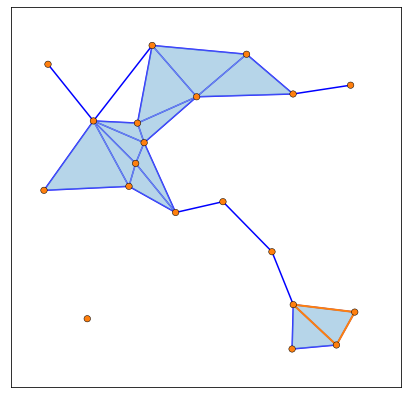

In [62]:
draw_2d_simplicial_complex(L, pointsM, markedEdges=ReprEdges)

## Proof that edges in the representative cycles are in $L$ 

1. All is manifold: so every edge is the boundary of at most 2 triangles
2. Since it's $Z_2$, an edge is in the cycle iff it is the boundary of only one triangle corresponding to a point in $\bar{L}$.
3. This means that the edge is also the boundary of a triangle in $L$, or the edge is in $L$ and not the boundary of any triangle in $L$, such as the outer rim ?